<a href="https://colab.research.google.com/github/deep-diver/TFX-WandB/blob/main/notebooks/dataset_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook to prepare TFRecord for TFX pipeline

This notebook shows how to prepare TFRecords for TFX pipeline with the [beans](https://huggingface.co/datasets/beans) dataset from Hugging Face's datasets library.

### Setup


In [ ]:
!pip install datasets

In [ ]:
import argparse
import math
import os
from typing import Tuple

import datasets
import numpy as np
import tensorflow as tf
import tqdm
from PIL import Image

import matplotlib.pyplot as plt

RESOLUTION = 256

### Utility functions

#### download dataset and get its train and test datasets from `datasets` lib

In [ ]:
def load_beans_dataset(split, seed=2023):
    hf_dataset_identifier = "beans"
    ds = datasets.load_dataset(hf_dataset_identifier)

    ds = ds.shuffle(seed=1)
    ds = ds["train"].train_test_split(test_size=split, seed=seed)
    train_ds = ds["train"]
    val_ds = ds["test"]

    return train_ds, val_ds

#### preprocessing the datasets 

In [ ]:
def resize_img(
    image: tf.Tensor, label: tf.Tensor, resize: int
) -> Tuple[tf.Tensor, tf.Tensor]:
    image = tf.image.resize(image, (resize, resize))
    return image, label


def process_image(
    image: Image, label: Image, resize: int
) -> Tuple[tf.Tensor, tf.Tensor]:
    image = np.array(image)
    label = np.array(label)

    image = tf.convert_to_tensor(image)
    label = tf.convert_to_tensor(label)

    if resize:
        image, label = resize_img(image, label, resize)

    return image, label

#### structure TFRecord

In [ ]:

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_tfrecord(image: Image, label: Image, resize: int):
    image, label = process_image(image, label, resize)
    image_dims = image.shape

    image = tf.reshape(image, [-1])  # flatten to 1D array
    label = tf.reshape(label, [-1])  # flatten to 1D array

    return tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": _float_feature(image.numpy()),
                "image_shape": _int64_feature(
                    [image_dims[0], image_dims[1], image_dims[2]]
                ),
                "label": _int64_feature(label.numpy()),
            }
        )
    ).SerializeToString()

#### save TFRecords

In [ ]:
def write_tfrecords(root_dir, dataset, split, batch_size, resize):
    print(f"Preparing TFRecords for split: {split}.")

    for step in tqdm.tnrange(int(math.ceil(len(dataset) / batch_size))):
        temp_ds = dataset[step * batch_size : (step + 1) * batch_size]
        shard_size = len(temp_ds["image"])
        filename = os.path.join(
            root_dir, "{}-{:02d}-{}.tfrec".format(split, step, shard_size)
        )

        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(shard_size):
                image = temp_ds["image"][i]
                label = temp_ds["labels"][i]
                example = create_tfrecord(image, label, resize)
                out_file.write(example)
            print("Wrote file {} containing {} records".format(filename, shard_size))

### Test out the functions

In [ ]:
root_tfrecord_dir = "beans-tfrecords"
batch_size = 32
resize = 256

In [ ]:
!mkdir $root_tfrecord_dir

In [ ]:
train_ds, val_ds = load_beans_dataset(0.2)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
write_tfrecords(
    root_tfrecord_dir, train_ds, "train", batch_size, resize
)

Preparing TFRecords for split: train.


<ipython-input-14-887288ffbfaf>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for step in tqdm.tnrange(int(math.ceil(len(dataset) / batch_size))):


  0%|          | 0/26 [00:00<?, ?it/s]

Wrote file beans-tfrecords/train-00-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-01-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-02-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-03-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-04-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-05-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-06-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-07-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-08-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-09-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-10-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-11-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-12-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-13-32.tfrec containing 32 records
Wrote file beans-tfrecords/train-14-32.tfrec containing 32 rec

In [ ]:
write_tfrecords(
    root_tfrecord_dir, val_ds, "val", batch_size, resize
)

Preparing TFRecords for split: val.


<ipython-input-14-887288ffbfaf>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for step in tqdm.tnrange(int(math.ceil(len(dataset) / batch_size))):


  0%|          | 0/7 [00:00<?, ?it/s]

Wrote file beans-tfrecords/val-00-32.tfrec containing 32 records
Wrote file beans-tfrecords/val-01-32.tfrec containing 32 records
Wrote file beans-tfrecords/val-02-32.tfrec containing 32 records
Wrote file beans-tfrecords/val-03-32.tfrec containing 32 records
Wrote file beans-tfrecords/val-04-32.tfrec containing 32 records
Wrote file beans-tfrecords/val-05-32.tfrec containing 32 records
Wrote file beans-tfrecords/val-06-15.tfrec containing 15 records


### Test if TFRecord is correctly constructed 

In [ ]:
BATCH_SIZE = 4
AUTO = tf.data.AUTOTUNE

In [ ]:
def parse_tfr(proto):
    feature_description = {
        "image": tf.io.VarLenFeature(tf.float32),
        "image_shape": tf.io.VarLenFeature(tf.int64),
        "label": tf.io.VarLenFeature(tf.int64),
    }
    rec = tf.io.parse_single_example(proto, feature_description)
    image_shape = tf.sparse.to_dense(rec["image_shape"])
    image = tf.reshape(tf.sparse.to_dense(rec["image"]), image_shape)
    label = tf.sparse.to_dense(rec["label"])
    return {"pixel_values": image, "label": label}


def prepare_dataset(PATH=root_tfrecord_dir, 
                    split="train", batch_size=BATCH_SIZE):

    if split not in ["train", "val"]:
        raise ValueError(
            "Invalid split provided. Supports splits are: `train` and `val`."
        )

    dataset = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(f"{PATH}/{split}-*")],
        num_parallel_reads=AUTO,
    ).map(parse_tfr, num_parallel_calls=AUTO)

    if split == "train":
        dataset = dataset.shuffle(batch_size * 2)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
train_dataset = prepare_dataset()
val_dataset = prepare_dataset(split="val")

In [ ]:
labels = ['angular_leaf_spot', 'bean_rust', 'healthy']

(4, 256, 256, 3) (4, 1)
angular_leaf_spot


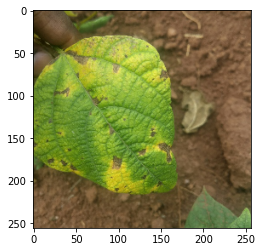

In [ ]:
for batch in train_dataset.take(1):
    print(batch["pixel_values"].shape, batch["label"].shape)
    a_image = tf.squeeze(batch["pixel_values"][0])
    plt.imshow(a_image.numpy().astype("uint8"))
    print(labels[batch["label"][0][0]])

(4, 256, 256, 3) (4, 1)
angular_leaf_spot


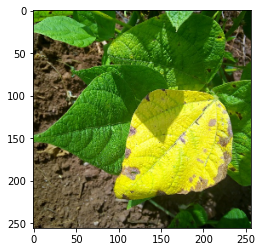

In [ ]:
for batch in val_dataset.take(1):
    print(batch["pixel_values"].shape, batch["label"].shape)
    a_image = tf.squeeze(batch["pixel_values"][0])
    plt.imshow(a_image.numpy().astype("uint8"))
    print(labels[batch["label"][0][0]])